In [1]:
!python --version

Python 3.10.13


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, time, datetime
import json, pickle
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import tree based models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# training/testing utils
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

# Symbolic regression
from gplearn.genetic import SymbolicClassifier

## Load data

In [4]:
data = pd.read_csv('../data/data_diet_filtered.csv', index_col=0)

data.disease, enc_values = pd.factorize(data.disease) # to get back original labels, do "enc_values[data.disease]"

drop_col = ['index', 'disease', 'subject_id','gender', 'country','age_category', 'diet']
X = data.drop(labels=drop_col, axis=1)
y = data.disease.values

class_map = {v: k for v, k in enumerate(list(enc_values.values))}  # coded label to names
class_counts = {k: len(y[y==v]) for v, k in enumerate(list(enc_values.values))}
assert sum([class_counts[k] for k in class_counts]) == len(X), 'total #samples not matching when summing for each class'

print(data.shape, X.shape, y.shape, class_map, class_counts)

(14560, 756) (14560, 749) (14560,) {0: 'healthy', 1: 'IBD', 2: 'CRC', 3: 'adenoma', 4: 'T2D'} {'healthy': 10761, 'IBD': 1736, 'CRC': 701, 'adenoma': 209, 'T2D': 1153}


/var/folders/qp/4w02sqhj6_d43815lhzjb7900000gn/T/ipykernel_76277/129412594.py:1: DtypeWarning: Columns (756) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/data_diet_filtered.csv', index_col=0)


In [5]:
# only take normalized rows!
normalized_idx = (X.sum(1) > 99)
X = X[normalized_idx]
y = y[X.index]

print(f"X.shape: {X.shape}, y.shape: {y.shape}")

X.shape: (14156, 749), y.shape: (14156,)


In [6]:
from srmb.utils import calculate_metrics
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

## Healthy vs. CRC classification
For the subsequent analysis, we will only choose the healthy and CRC patients from the 
dataset.

In [7]:
from srmb.fitness_functions import customacc
from srmb.special_functions import (
    presence, absence, add3, add10, ifelse, ifelseless,
    presence2, absence2,
    presence3, absence3
)

Error exception: Only one class present in y_true. ROC AUC score is not defined in that case.


In [8]:
k = 2
idxs = (y == 0) | (y == k)  # get healthy and that class' data

X1, y1 = X.iloc[idxs], y[idxs]
y1[y1 == k] = 1  # relabel 1 --> CRC, 0 --> healthy
print(f'doing for class = {class_map[k]}, {X1.shape=}, {y1.shape=}, #{class_map[k]} samples = {y1.sum()}')

doing for class = CRC, X1.shape=(11137, 749), y1.shape=(11137,), #CRC samples = 664


## Fit an XGboost model (top performing) in the baseline experiment, and distill its _knowledge_ with a symbolic regression estimator

In [9]:
USE_BALANCED_SUBSAMPLE = True

random_state = 42

rus = RandomUnderSampler(sampling_strategy=0.85, # this is another hyperparameter
                         random_state=random_state)
X1b, y1b = rus.fit_resample(X1, y1)
print(f'seed={random_state}')
print(sorted(Counter(y1b).items()))

if not USE_BALANCED_SUBSAMPLE:
    X_train, X_test, y_train, y_test = train_test_split(X1, y1,
                                                    test_size=0.25,
                                                    # train_size=0.5, # if slow use this
                                                    random_state=random_state, stratify=y1)
    class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y1), y=y1)
else:
    # print('using a balanced subsample of the data ...')
    X_train, X_test, y_train, y_test = train_test_split(X1b, y1b,
                                                        test_size=0.25,
                                                        # train_size=0.5, # if slow use this
                                                        random_state=42, stratify=y1b)
    class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y1b), y=y1b)


sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Create an XGBoost classifier for multiclass classification
model_xg = XGBClassifier(n_estimators=50, max_depth=5, learning_rate=0.1, objective='binary:logistic')
model_xg.fit(X_train, y_train, sample_weight=sample_weights)

calculate_metrics(model_xg, X_train, y_train, X_test, y_test)

seed=42
[(0, 781), (1, 664)]
XGBClassifier
Test accuracy: 0.8260 Test AUROC: 0.9131 Test F1 score: 0.8013


(0.8259668508287292, 0.8012618296529969, 0.9130808950086059)

In [10]:
# Prepare labels
y_train_xg = model_xg.predict(X_train)
y_train_xg_prob = model_xg.predict_proba(X_train)[:, 1]

y_test_xg = model_xg.predict(X_test)
y_test_xg_prob = model_xg.predict_proba(X_test)[:, 1]

## KD using symbolic classifier

In [11]:
# SR with special functions
special_functions = [presence, absence, presence2, absence2, ifelse, ifelseless]#, add3, add10]
function_set = special_functions

est = SymbolicClassifier(population_size=6000,
                         generations=20,
                         tournament_size=25,

                         init_depth=(2, 6),
                         const_range=(0., 100.),
                         init_method="full",
                         parsimony_coefficient=0.008,
                         function_set=function_set,

                         stopping_criteria=1.0, metric=customacc, #use custom acc as fitness

                         feature_names=X1.columns.to_list(),
                         verbose=True,
                         random_state=42)

t0 = time.time()
est.fit(X_train, y_train_xg)
print('Time to fit symbolic classifier:', time.time() - t0, 'seconds')
calculate_metrics(est, X_train, y_train_xg, X_test, y_test_xg)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    22.82         0.517538        4         0.711911              N/A     45.38s
   1     5.72         0.534879       10         0.734995              N/A     37.07s
   2     5.04         0.554695       10         0.771006              N/A     35.81s
   3     2.49         0.622424        9         0.790397              N/A     32.07s
   4     1.46         0.705008        9          0.79132              N/A     30.05s
   5     2.34         0.622646        9         0.803324              N/A     27.88s
   6     4.26         0.534865        4          0.79132              N/A     26.79s
   7     4.84          0.53956        5          0.79132              N/A     25.19s
   8     4.78         0.553456        8          0.79132              N/A  

(0.8093922651933702, 0.739622641509434, 0.7865886193151502)

In [12]:
from IPython.display import display, Image
from srmb.utils import load_sr_models, create_graph, graph_to_jpg

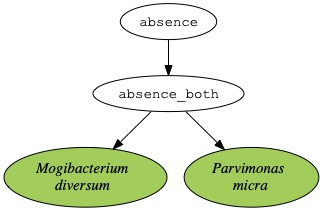

In [13]:
G = create_graph(est)
display(Image(graph_to_jpg(G,
                           path="../results_srmb/xgboost_distilled_sr.jpg"), width=500, unconfined=True)
       )
